<a href="https://colab.research.google.com/github/priangshu17/AIRL-Coding-Assignment/blob/main/q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import random, os
import math

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),  # Random Crop with padding
    transforms.RandomHorizontalFlip(),       # Flip 50% of the time
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))
])

In [4]:
trainset = torchvision.datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform_train)
testset = torchvision.datasets.CIFAR10(root = "./data", train = False, download = True, transform = transform_test)

100%|██████████| 170M/170M [00:03<00:00, 46.9MB/s]


In [5]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 128, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 128, shuffle = False)

In [6]:
classes = trainset.classes

In [7]:
class PatchEmbedding(nn.Module):
  def __init__(self, img_size = 32, patch_size = 4, in_channels = 3, embed_dim = 128):
    super().__init__()
    self.num_patches = (img_size // patch_size) ** 2
    self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size = patch_size, stride = patch_size)

  def forward(self, x):
    # x : [B, C, H, W]
    x = self.patch_embed(x)  # [B, embed_dim, H/patch, W/patch]
    x = x.flatten(2)         # [B, embed_dim, num_patches]
    x = x.transpose(1, 2)    # [B, num_patches, embed_dim]
    return x

In [8]:
class ViT(nn.Module):
  def __init__(self, img_size = 32, patch_size = 4, in_channels = 3, num_classes = 10, embed_dim = 192, depth = 8, num_heads = 12, mlp_dim = 256):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
    num_patches = self.patch_embed.num_patches

    # CLS Token
    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    # Positional Embedding
    self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

    # Transformer Encoder Layer
    encoder_layer = nn.TransformerEncoderLayer(d_model = embed_dim,
                                               nhead = num_heads,
                                               dim_feedforward = mlp_dim,
                                               batch_first = True)
    self.transformer = nn.TransformerEncoder(encoder_layer, num_layers = depth)


    # Classification Head
    self.mlp_head = nn.Sequential(
        nn.LayerNorm(embed_dim),
        nn.Linear(embed_dim, num_classes)
    )

  def forward(self, x):
    B = x.shape[0]
    x = self.patch_embed(x)  # [B, num_patches, embed_dim]

    cls_token = self.cls_token.expand(B, -1, -1)  # [B, 1, embed_dim]
    x = torch.cat((cls_token, x), dim = 1)  # Prepend CLS

    x = x + self.pos_embed   # Add positional embeddings
    x = self.transformer(x)

    cls_output = x[:, 0]  # CLS Token
    return self.mlp_head(cls_output)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
model = ViT().to(device)

In [11]:
loss_fn = nn.CrossEntropyLoss()

In [12]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR

In [13]:
num_epochs = 50
base_lr = 3e-4
weight_decay = 0.01
warmup_epochs = 5
batch_size = 128

In [14]:
optimizer = optim.AdamW(model.parameters(), lr = base_lr, weight_decay = weight_decay)

In [15]:
def lr_lambda(current_epoch):
  if current_epoch < warmup_epochs:
    # linear warmup 0 -> 1
    return float(current_epoch) / float(max(1, warmup_epochs))

  # Cosine decay from 1 -> 0
  progress = float(current_epoch - warmup_epochs) / float(max(1, num_epochs - warmup_epochs))
  return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = LambdaLR(optimizer, lr_lambda)

In [16]:
def evaluate_loss_acc(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return total_loss / len(loader), 100.0 * correct / total


In [17]:
train_losses, test_losses = [], []
train_accs, test_accs = [], []
lrs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Scheduler step per epoch (after optimizer.step)
    scheduler.step()
    lrs.append(optimizer.param_groups[0]['lr'])

    train_loss = running_loss / len(train_loader)
    train_acc = 100.0 * correct / total
    test_loss, test_acc = evaluate_loss_acc(model, test_loader, loss_fn, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1:02d} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

Epoch 01 | LR: 0.000060 | Train Loss: 2.4430 | Train Acc: 10.14% || Test Loss: 2.4324 | Test Acc: 10.16%
Epoch 02 | LR: 0.000120 | Train Loss: 1.9232 | Train Acc: 28.25% || Test Loss: 1.7966 | Test Acc: 33.15%
Epoch 03 | LR: 0.000180 | Train Loss: 1.6601 | Train Acc: 38.32% || Test Loss: 1.5396 | Test Acc: 44.50%
Epoch 04 | LR: 0.000240 | Train Loss: 1.4291 | Train Acc: 48.14% || Test Loss: 1.3482 | Test Acc: 51.18%
Epoch 05 | LR: 0.000300 | Train Loss: 1.2852 | Train Acc: 53.32% || Test Loss: 1.1805 | Test Acc: 57.83%
Epoch 06 | LR: 0.000300 | Train Loss: 1.1810 | Train Acc: 57.08% || Test Loss: 1.0626 | Test Acc: 61.53%
Epoch 07 | LR: 0.000299 | Train Loss: 1.0911 | Train Acc: 60.76% || Test Loss: 0.9906 | Test Acc: 64.26%
Epoch 08 | LR: 0.000297 | Train Loss: 1.0178 | Train Acc: 63.57% || Test Loss: 0.9724 | Test Acc: 64.80%
Epoch 09 | LR: 0.000294 | Train Loss: 0.9674 | Train Acc: 65.47% || Test Loss: 0.8876 | Test Acc: 68.51%
Epoch 10 | LR: 0.000291 | Train Loss: 0.9186 | Train Ac

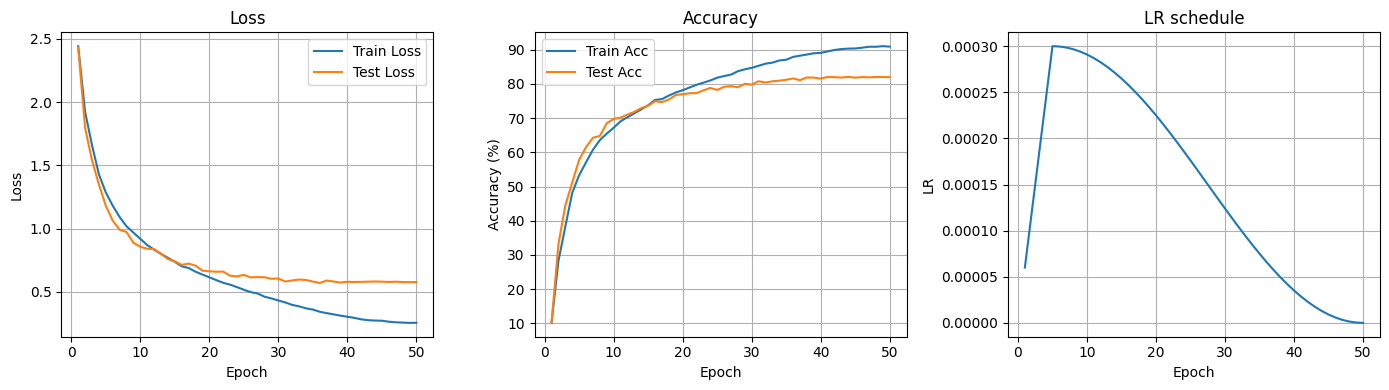

In [18]:
epochs = range(1, num_epochs+1)

plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend(); plt.grid(True)

plt.subplot(1,3,2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, test_accs, label='Test Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy'); plt.legend(); plt.grid(True)

plt.subplot(1,3,3)
plt.plot(epochs, lrs, label='LR')
plt.xlabel('Epoch'); plt.ylabel('LR'); plt.title('LR schedule'); plt.grid(True)

plt.tight_layout()
plt.show()